In [1]:
import pandas as pd
# Load the dataset
# convert_shot.csv is a csv file generated from transform.py
data = pd.read_csv('../dataset/doubles 2/doubles/convert_shot.csv',encoding='utf-8')

# Filter players
players_filtered = data[~((data['rally_id'] >= 73) & (data['rally_id'] <= 143))]

# Initialize the list to collect rows
rows_list_win = []
rows_list_lose = []

# Initialize previous shot variable
prev = ""

# Iterate over the filtered DataFrame rows
for _, row in players_filtered.iterrows():
    if row['shot_num'] == 1:
        continue
    # check ball type
    if (row['ball_type'] == '擋小球') or (row['ball_type'] == '勾球') or (row['ball_type'] == '放小球') or (row['ball_type'] == '小平球') > 0:
        row['ball_type'] = '網前小球'
    elif (row['ball_type'] == '防守回挑'):
        row['ball_type'] = '挑球'
    elif (row['ball_type'] == '防守回抽') or (row['ball_type'] == '後場抽平球') > 0:
        row['ball_type'] = '平球'
    elif (row['ball_type'] == '過度切球'):
        row['ball_type'] = '切球'
    elif (row['ball_type'] == '推球') or (row['ball_type'] == '撲球') > 0:
        row['ball_type'] = '推撲球'
    if row['player'] != 14 and row['player'] != 33:
        prev = row["ball_type"]
        continue
    newrow = {
        "hit_player_x": None,
        "hit_player_y": None,
        "partner_x": None,
        "partner_y": None,
        "ball_type": row["ball_type"],
        "挑球": 0,
        "殺球": 0,
        "平球": 0,
        "網前小球": 0,
        "切球": 0,
        "推撲球": 0,
        "長球": 0
    }
    if (row['hit_y'] < 67) ^ (row['player_A_x'] < 67) == 0:
        if row['player'] == 14:
            newrow["hit_player_x"] = row['player_A_x']
            newrow["hit_player_y"] = row['player_A_y']
            newrow["partner_x"] = row['player_B_x']
            newrow["partner_y"] = row['player_B_y']
        else:
            newrow["hit_player_x"] = row['player_B_x']
            newrow["hit_player_y"] = row['player_B_y']
            newrow["partner_x"] = row['player_A_x']
            newrow["partner_y"] = row['player_A_y']
    else:
        if row['player'] == 14:
            newrow["hit_player_x"] = row['player_C_x']
            newrow["hit_player_y"] = row['player_C_y']
            newrow["partner_x"] = row['player_D_x']
            newrow["partner_y"] = row['player_D_y']
        else:
            newrow["hit_player_x"] = row['player_D_x']
            newrow["hit_player_y"] = row['player_D_y']
            newrow["partner_x"] = row['player_C_x']
            newrow["partner_y"] = row['player_C_y']
    
    if newrow["hit_player_y"] > 67:
        newrow["hit_player_x"] = 61 - newrow["hit_player_x"]
        newrow["hit_player_y"] = 134 - newrow["hit_player_y"]
        newrow["partner_x"] = 61 - newrow["partner_x"]
        newrow["partner_y"] = 134 - newrow["partner_y"]
    

    newrow[f'{prev}'] = 1
    
    # Ensure only valid ball types are added
    newrow["ball_type"] = row["ball_type"]
    
    # Filter out the first match (lose)
    if row['rally_id'] <= 1086 and row['rally_id'] >= 1025:
        rows_list_lose.append(newrow)
    else:
        rows_list_win.append(newrow)
    

# Create a new DataFrame from the list of rows
win_df = pd.DataFrame(rows_list_win)
lose_df = pd.DataFrame(rows_list_lose)

# Define the desired column order
column_order = [
    "hit_player_x", "hit_player_y", "partner_x", "partner_y",
    "挑球", "殺球", "平球", "網前小球", "切球", "推撲球", "長球", "ball_type"
]

# Reorder the columns
win_df = win_df[column_order]
lose_df = lose_df[column_order]

# Save the processed data
win_df.to_csv('../dataset/doubles 2/doubles/processed_shot_win.csv', index=False)
lose_df.to_csv('../dataset/doubles 2/doubles/processed_shot_lose.csv', index=False)

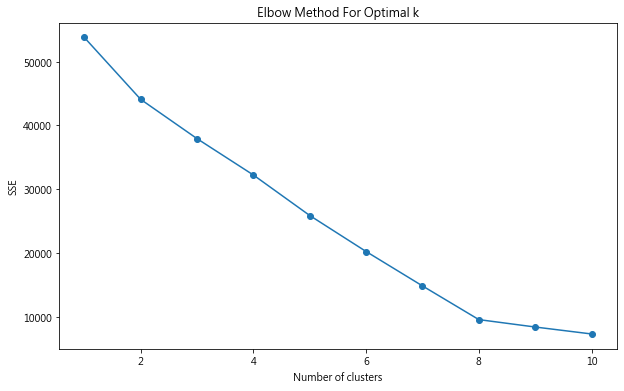

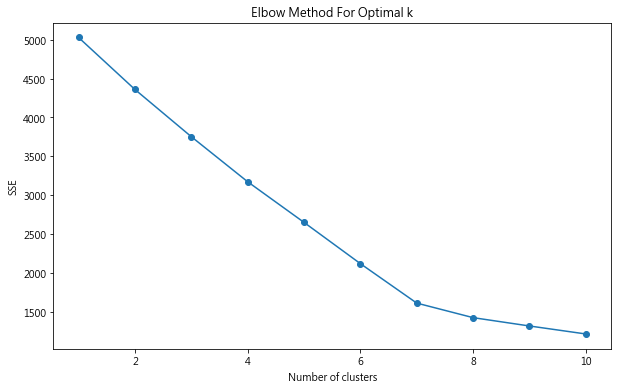

In [52]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# set traditional Chinese display
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

dataset_name = ['win', 'lose']
win_data = pd.read_csv('../dataset/doubles 2/doubles/processed_shot_win.csv')
lose_data = pd.read_csv('../dataset/doubles 2/doubles/processed_shot_lose.csv')

for name in dataset_name:
    data = win_data if name == 'win' else lose_data
    # select features
    features = data[["hit_player_x", "hit_player_y", "partner_x", "partner_y",
        "挑球", "殺球", "平球", "網前小球", "切球", "推撲球", "長球"]]
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # use elbow method to find the optimal k
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features_scaled)
        sse.append(kmeans.inertia_)

    # plot the elbow method
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.title('Elbow Method For Optimal k')
    plt.savefig(f'../output/Week5/elbow_plot_{name}.png')
    plt.show()

In [54]:
# clustering
n_win = 8  # Best n from elbow method
kmeans_win = KMeans(n_clusters=n_win)
win_data['cluster'] = kmeans_win.fit_predict(win_data[["hit_player_x", "hit_player_y", "partner_x", "partner_y",
        "挑球", "殺球", "平球", "網前小球", "切球", "推撲球", "長球"]])

n_lose = 7
kmeans_lose = KMeans(n_clusters=n_lose)
lose_data['cluster'] = kmeans_lose.fit_predict(lose_data[["hit_player_x", "hit_player_y", "partner_x", "partner_y",
        "挑球", "殺球", "平球", "網前小球", "切球", "推撲球", "長球"]])


In [55]:
# plot the clustering result
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# data_indices = data.index

for name in dataset_name:
    n = n_win if name == 'win' else n_lose
    data = win_data if name == 'win' else lose_data
    for cluster in range(0, n):
        plt.figure(figsize=(9.15, 10.05))
    
        cluster_data = data[data['cluster'] == cluster]
        if len(cluster_data) > 60:
            sample_cluster_data = cluster_data.sample(n=60, random_state=1)
        else:
            sample_cluster_data = cluster_data
    
        plt.scatter(sample_cluster_data['hit_player_x'], sample_cluster_data['hit_player_y'], color='r', label=f'Cluster {cluster} - Hit player')
        plt.plot([sample_cluster_data['hit_player_x'], sample_cluster_data['partner_x']], [sample_cluster_data['hit_player_y'], sample_cluster_data['partner_y']], color='y', label=f'Cluster {cluster} - Partner line') 
        plt.scatter(sample_cluster_data['partner_x'], sample_cluster_data['partner_y'], color='b', label=f'Cluster {cluster} - Partner')
        plt.plot([sample_cluster_data['hit_player_x'].mean(), sample_cluster_data['partner_x'].mean()], [sample_cluster_data['hit_player_y'].mean(), 
            sample_cluster_data['partner_y'].mean()], color='g', label=f'Cluster {cluster} - Mean line', linewidth=5)
    
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.xlim(0, 61) 
        plt.ylim(0, 67) 
        plt.savefig(f'../output/Week5/{name}_cluster_{cluster+1}_positions.jpg')
        plt.close()


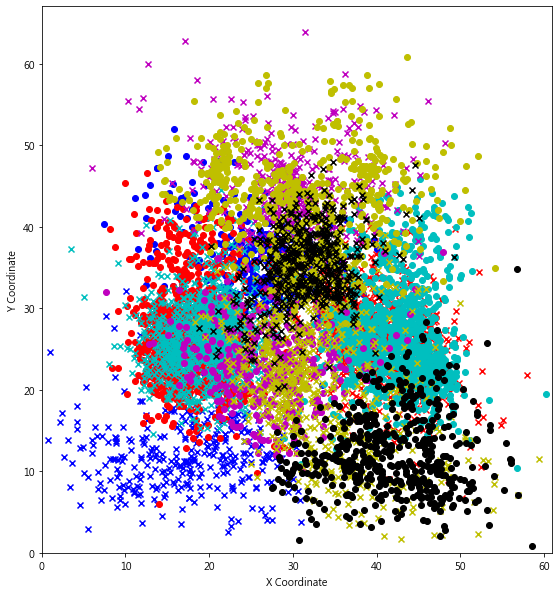

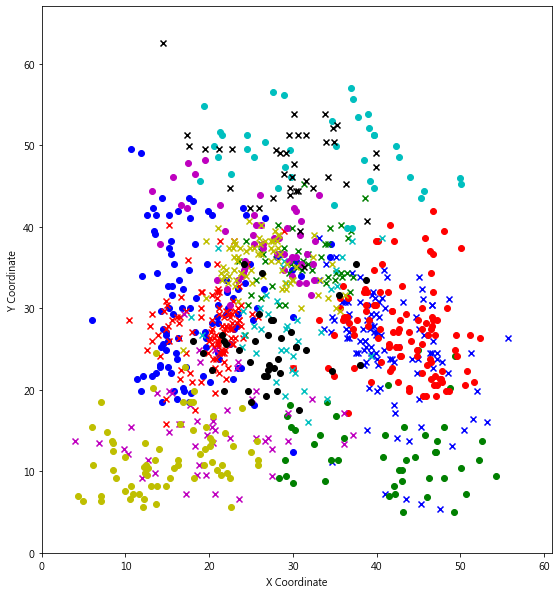

In [44]:
for name in dataset_name:
    data = win_data if name == 'win' else lose_data
    # plot all clustering results in one figure
    plt.figure(figsize=(9.15, 10.05))
    for cluster in range(n):
        cluster_data = data[data['cluster'] == cluster]
        plt.scatter(cluster_data['hit_player_x'], cluster_data['hit_player_y'], color=colors[cluster % len(colors)], label=f'Cluster {cluster} - Hit player')
        plt.scatter(cluster_data['partner_x'], cluster_data['partner_y'], color=colors[cluster % len(colors)], marker='x', label=f'Cluster {cluster} - Partner')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(0, 61) 
    plt.ylim(0, 67)
    # plt.legend()
    plt.savefig(f'../output/Week5/{name}_clusters_positions.jpg')
    plt.show()

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the ball types
ball_types = ["挑球", "殺球", "平球", "網前小球", "切球", "推撲球", "長球"]

for name in dataset_name:
    data = win_data if name == 'win' else lose_data
    n = n_win if name == 'win' else n_lose
    # Transform one-hot encoding to ball type strings for the opponent's shots
    data['opponent_ball_type'] = data[ball_types].idxmax(axis=1)
    for cluster in range(n):
        clustered_data = data[data['cluster'] == cluster]
        matrix = pd.crosstab(clustered_data['opponent_ball_type'], clustered_data['ball_type'], dropna=False)
        matrix = matrix.reindex(index=ball_types, columns=ball_types, fill_value=0)
        plt.figure(figsize=(10, 8))
        sns.heatmap(matrix, annot=True, fmt="g", cmap="YlGnBu", xticklabels=ball_types, yticklabels=ball_types)
        plt.xlabel("Our hit ball type")
        plt.ylabel("Opponent's hit ball type")
        plt.yticks(rotation=45)
        plt.savefig(f'../output/Week5/{name}_cluster_{cluster+1}_confusion_matrix.jpg')
        plt.close()


c:\Users\Admin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Admin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


In [51]:
print(win_data.index)
print(lose_data.index)

RangeIndex(start=0, stop=4891, step=1)
RangeIndex(start=0, stop=457, step=1)
